In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from astropy.io import fits
import os
import math
import random
from scipy import stats


In [2]:
Catalog = np.loadtxt('Data/SD-CH2.csv', delimiter=',', skiprows=1,dtype='str')
CatalogGOES = np.loadtxt('Data/SD-GOES.csv', delimiter=',', skiprows=1,dtype='str')

In [3]:
# Rise Time Data

Total_Time = Catalog[:,5].astype(float) - Catalog[:,1].astype(float)
Total_Time = Total_Time[Total_Time > 0]
print(min(Total_Time))
print(max(Total_Time))


10.0
15880.0


In [4]:
# Peak Flux Data
Peak_Count = Catalog[:, 4].astype(float)
# Pre_Peak_Count = Catalog[:, 27]

# Peak_Count = CatalogGOES[:, 4].astype(float)
# Pre_Peak_Count = CatalogGOES[:, 24]


Peak_Count = Peak_Count[Peak_Count != 0]

# Peak_Count = np.log(Peak_Count)
# # Peak_Count = Peak_Count[Peak_Count != -np.inf]
# print(max(Peak_Count))
# print(min(Peak_Count))
# print(np.average(Peak_Count))
# print(len(Peak_Count))  



In [5]:
def calcHist(x, bins):    

    nbins = np.log10(np.logspace(np.log10(min(x)), np.log10(max(x)), bins+1))

    hist, bin_edges = np.histogram(np.log10(x), bins=nbins)

    bin_edges = 10**bin_edges
    bin_width = np.diff(bin_edges)

    scaled_hist = hist / bin_width
    

    return bin_edges[:-1], hist, scaled_hist

def plotStepHist(x, y):
    plt.step(x, y, color='#79c9bc', label='Post')
    # plt.scatter(x, y, color='#79c9bc', alpha=0.5)
    plt.xlabel('Peak Flux (nWm^-2)')
    plt.ylabel('Number of Events/ Peak Flux')
    plt.title('Histogram of Flux (Log-Log Scale)')
    plt.minorticks_on()
    plt.xscale('log')
    plt.yscale('log')
    # plt.ylim(1e5,1e16)
    plt.legend()
    plt.show()

In [33]:
fluence = np.loadtxt('Data/fluence.txt')

Peak_Count = fluence
Peak_Count = Peak_Count[Peak_Count != 0]
# Peal_Count = Peak_Count[Peak_Count > 1e6]

In [22]:
Peak_Count = Total_Time

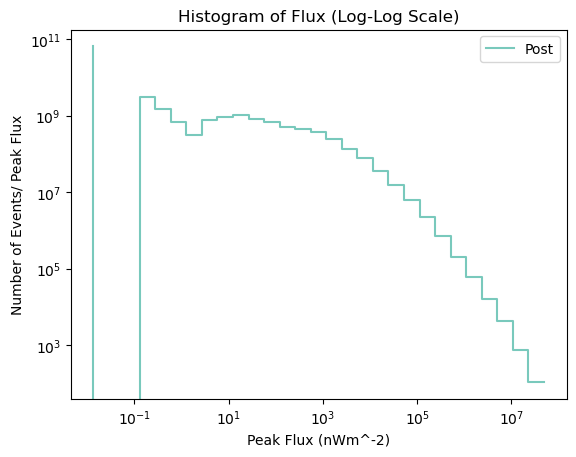

In [34]:
nobin = 30

bin_edges, hist, scaled_hist = calcHist(Peak_Count,nobin)
scaled_hist = scaled_hist*10**9

plotStepHist(bin_edges, scaled_hist)#/(bin_edges*10**-9))

In [35]:
"""
Paper Mentions the Turnover point to be around 2x10-6 Wm-2
i have added 2e3 (cause 1e-9 multp factor) 
"""


# Filter out zero and negative values from Peak_Count
# Peak_Count = Peak_Count[Peak_Count > 1]

def PowerLaw(x, a, A):
    return A * np.power(x, -a)
# def PowerLaw(x,a,A):
#     return A*np.power(x,-a)

/tmp/ipykernel_94598/2715742722.py:11: RuntimeWarning: overflow encountered in power
  return A * np.power(x, -a)


[1.61659335e+00 1.59437226e+15]


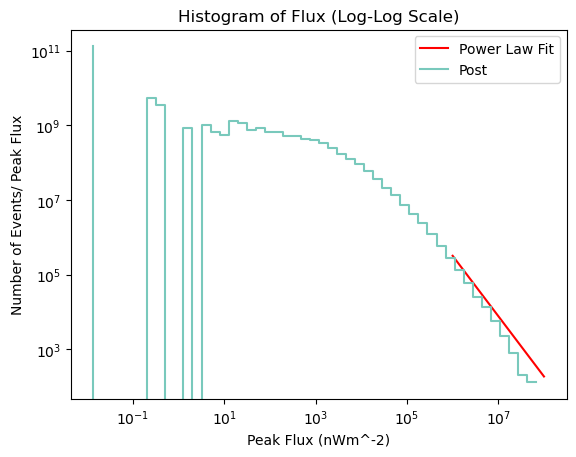

In [65]:
nobin = 50

bin_edges, hist, scaled_hist = calcHist(Peak_Count,nobin)
scaled_hist = scaled_hist*10**9

x_min = 1e6
x_max = 1e8
mask = (bin_edges>x_min)&(bin_edges < x_max)
# mask = bin_edges[cond]
bin_edges_masked = bin_edges[mask]
scaled_hist_masked = scaled_hist[mask]

popt, _ = curve_fit(PowerLaw, bin_edges_masked, scaled_hist_masked, \
                       p0=[2,max(scaled_hist_masked)*10**9] , maxfev=1000000)

print(popt)

xFit = np.linspace(x_min, x_max, 1000)
#xFit = calcHist(Peak_Count,nobin)[0]
yFit = PowerLaw(xFit, *popt)

plt.plot(xFit, yFit, color='red', label='Power Law Fit')
plt.xscale('log')
plt.yscale('log')
plotStepHist(bin_edges, scaled_hist)


In [51]:
# Monte Carlo Acha Wala

alphas = []
Xmins = []


for i in range(10000):
    
    nbins = random.randint(20,50)
    m = 7
    v = 0.5
    mu = np.log(m) - np.log((v/(m*m)) + 1)/2
    sigma = np.sqrt(np.log((v/(m*m)) + 1))
    xhigh = np.random.lognormal(mean=mu,sigma=sigma)

    bin_edges, hist, scaled_hist = calcHist(Peak_Count, nbins)
    bin_width = (np.log10(bin_edges[1]) - np.log10(bin_edges[0]))

    m = 4.5
    v = 0.5
    mu2 = np.log(m) - np.log((v/(m*m)) + 1)/2
    sigma2 = np.sqrt(np.log((v/(m*m)) + 1))

    xmin = np.random.lognormal(mean=mu2,sigma=sigma2)

    xmin = 10**xmin
    xhigh = 10**xhigh

    mask = (bin_edges>xmin)&(bin_edges < xhigh)
    # mask = bin_edges[cond]
    bin_edges_masked = bin_edges[mask]
    scaled_hist_masked = scaled_hist[mask]

    if(len(scaled_hist_masked)<2):
        continue
    
    popt, _ = curve_fit(PowerLaw,bin_edges_masked,scaled_hist_masked, \
                    p0=[2,max(scaled_hist_masked)*10**9], maxfev=10000)

    alpha = popt[0]
    print("alpha", alpha)
    # print("xmin", xmin)
    # print("xhigh", xhigh)
    # print("-------------------")

    alphas.append(alpha)
    Xmins.append(xmin)
    

# make a 2d array of Xmins and alphas
AlphaXmin = list(zip(alphas, Xmins))
AlphaXmin = np.array(AlphaXmin)
AlphaXmin = sorted(AlphaXmin, key=lambda x: x[1])


alpha 1.1777084473185797
alpha 1.0588847753573225
alpha 1.2410978187244142
alpha 1.034034685898171
alpha 0.9343149060952225
alpha 1.2857415470166125
alpha 0.854572775274319
alpha 1.6347995382296356
alpha 1.3454881483832433
alpha 1.400325277886978
alpha 1.1184725451238728
alpha 0.8313978379541463
alpha 1.1501790813834294
alpha 1.2048409596392808
alpha 1.1799186881639725
alpha 0.918833727703037
alpha 1.344867856434445
alpha 1.2856897741134037
alpha 1.5908496029800323
alpha 1.0340290781798565
alpha 1.326096744149687
alpha 0.8735158276487457
alpha 1.6327379635946868
alpha 1.34947708233291
alpha 1.586629313195637
alpha 1.23362410743059
alpha 1.2403331587643798
alpha 1.136830202467276
alpha 1.0623617178933304
alpha 1.6302642756240169
alpha 0.8574206485484792
alpha 1.264074646902276
alpha 1.2549492565490201
alpha 1.2921732393992678
alpha 0.9514243789361548
alpha 1.1599373456899282
alpha 1.717580305823356
alpha 1.5304788821986863
alpha 1.514287229782853
alpha 1.3299338565112333
alpha 0.9234197

/tmp/ipykernel_94598/2715742722.py:11: RuntimeWarning: overflow encountered in power
  return A * np.power(x, -a)
/tmp/ipykernel_94598/2715742722.py:11: RuntimeWarning: overflow encountered in multiply
  return A * np.power(x, -a)


alpha 1.0025940807080886
alpha 0.8278237720947509
alpha 1.5498164629571423
alpha 1.1697457206853359
alpha 1.155972183777678
alpha 1.254864588896662
alpha 1.096599495085747
alpha 1.4584454349420601
alpha 1.155972183777678
alpha 1.9212538094807492
alpha 1.1522617502289845
alpha 1.255586834260037
alpha 1.6218844972797657
alpha 1.2100107163562455
alpha 0.8537020753954863
alpha 1.7650374971604506
alpha 1.261136758681047
alpha 1.1459451475800917
alpha 1.138736515991808
alpha 1.7553390919231402
alpha 1.1490645026022808
alpha 1.2858679409779263
alpha 1.3715419889857285
alpha 1.3814955057057938
alpha 1.0296943869150792
alpha 1.3129059247210944
alpha 0.758400215499862
alpha 1.1796916346980033
alpha 1.6293922345011562
alpha 1.1366923520390286
alpha 1.1545096399752892
alpha 1.0966356582721126
alpha 1.3495335731306883
alpha 1.162621596346148
alpha 1.0297325105500776
alpha 1.5208491427806738
alpha 1.2858352187204598
alpha 1.3046562412573415
alpha 1.2216936897039268
alpha 1.2099845511409997
alpha 1.1

In [11]:
# make a 2d array of Xmins and alphas
AlphaXmin = list(zip(alphas, Xmins))
AlphaXmin = np.array(AlphaXmin)
AlphaXmin = sorted(AlphaXmin, key=lambda x: x[1])


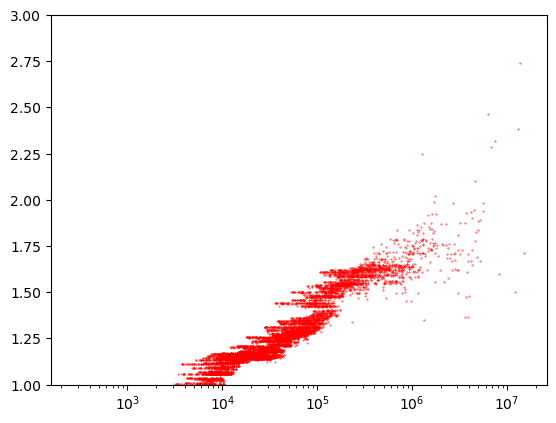

In [52]:
# Flatten the list of arrays or convert it to a numpy array
plt.scatter(Xmins,alphas, color='red', s = 0.1)
plt.xscale('log')
plt.ylim((1,3))
plt.show()      

In [53]:
def normalize_values(values):
    min_val = min(values)
    max_val = max(values)
    
    normalized_values = [(x - min_val) / (max_val - min_val) for x in values]
    
    return normalized_values

def stability(vals):
    std_vals = []
    space = 5
    for i in range(1,len(vals),space):
        curr_vals = []
        val_range = vals[i:i+space]
        val_range = np.array(val_range)
        val_range.sort(axis=0)

        alpha_vals = val_range[:,0]
        xmin_vals = np.array(val_range[:,1])
        alpha_vals = normalize_values(alpha_vals)
        alpha_vals = np.array(alpha_vals)

        std = np.std(alpha_vals)

        curr_vals.append(std)
        curr_vals.append(xmin_vals)
        curr_vals.append(val_range[:,0])

        std_vals.append(curr_vals)
    return std_vals

def estRapidity(x,y,thres):
    result = []
    diff = []
    for i in range(1, len(y)):
        difference = y[i] - y[i - 1]
        diff.append(difference)
        if abs(difference) >= thres:
            result.append(x[i])
            result.append(y[i])
            break
    return result, diff


[4.346552573353257e-05, 5.427380722949904e-05, 0.00014840253789238922, 0.0005864868793278855, 5.822274135824923e-05, 0.00012733037575007877, 1.2413051677373499e-05, 4.164532823436318e-05, 7.133918617174828e-05, 4.6459625064554366e-05, 7.291556341382233e-06, 0.00016962248718593864, 3.9849504813616043e-05, 7.551925430582251e-05, 4.9571137801351917e-05, 5.018910398141285e-05, 0.00021901624547587817, 6.754102476430601e-05, 2.2992487989703658e-05, 4.9781922295544234e-05, 0.00021667339436870492, 5.726328539223946e-05, 0.00023615349090272408, 5.739638010376913e-05, 6.591742658978994e-05, 8.974895510266423e-05, 6.461104154786845e-05, 0.00014421317820212387, 1.946870562408165e-05, 0.00010189711158015147, 9.608448195308483e-05, 8.989506760342936e-05, 0.0004923070206823144, 0.00010213094322270022, 0.00016511824708403955, 0.00016825276511500675, 4.785290749770299e-05, 3.3949139796596306e-06, 0.00013964791640375118, 2.74503536240589e-06, 0.00010154642227960808, 0.00023825251932774183, 0.00020022322

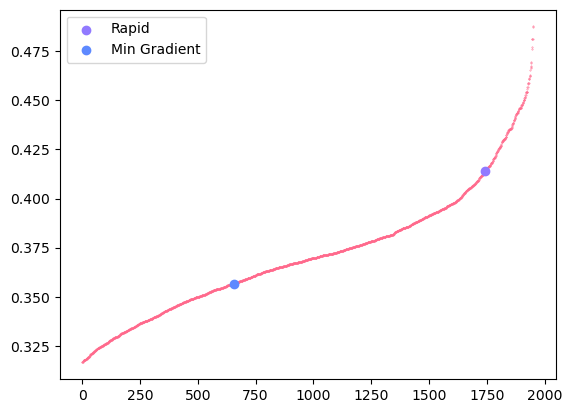

xmin [13363.09190846 13364.33730696 13366.81655691 13367.67716629
 13371.00095089]
alpha [1.11543053 1.11917217 1.14471631 1.15178857 1.16811568]
std 0.378572264182937
-----------------------
xmin [202548.87393121 203023.40393916 203547.74479401 203600.69412156
 203609.06436106]
alpha [1.5438737  1.55029118 1.58688134 1.61685766 1.61696354]
std 0.42899166989779686
Average Alpha 1.5829734848535975


In [69]:
stab_vals = stability(AlphaXmin)

std_vals = []
alpha_vals = []
for i in stab_vals:
    std_vals.append(i[0])
    alpha_vals.append(i[2])


xvals = np.linspace(0,len(std_vals),len(std_vals))
std_vals.sort()

dy_dx = np.gradient(std_vals, xvals)
xfil_vals = xvals[~np.isnan(dy_dx)]
dy_dx = dy_dx[~np.isnan(dy_dx)]

dy2_d2x = np.gradient(dy_dx, xfil_vals)

min_gradient_index = np.argmin(np.abs(dy_dx))

rapid_data, diff = estRapidity(xvals, std_vals, 0.0006)
print(diff)

# #plot histogram of diff
# plt.hist(dy2_d2x, bins=1000)
# # plt.xlim(0,0.0006)
# plt.xscale('log')


plt.scatter(xvals,std_vals, color='#ff698c', s = 0.1)
plt.scatter(rapid_data[0], rapid_data[1], color='#917aff', label='Rapid')
plt.scatter(xvals[min_gradient_index], std_vals[min_gradient_index], color='#5e89ff', label='Min Gradient')
plt.legend()                                                         
plt.show()

print("xmin", stab_vals[min_gradient_index][1])
print("alpha", stab_vals[min_gradient_index][2])
print("std", stab_vals[min_gradient_index][0])
print('-----------------------')
print("xmin", stab_vals[np.where(std_vals == rapid_data[1])[0][0]][1])
print("alpha", stab_vals[np.where(std_vals == rapid_data[1])[0][0]][2])
print("std", stab_vals[np.where(std_vals == rapid_data[1])[0][0]][0])

print("Average Alpha", np.average(stab_vals[np.where(std_vals == rapid_data[1])[0][0]][2]))

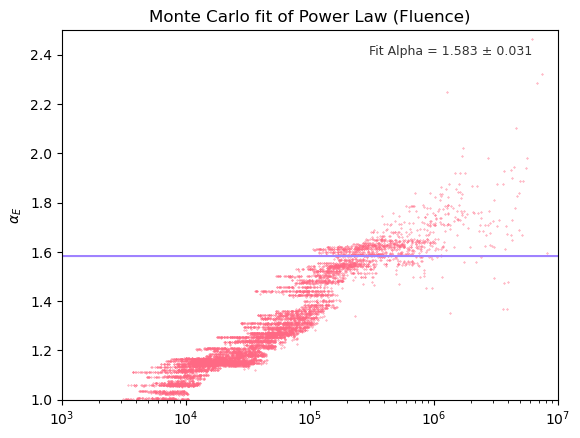

In [80]:
plt.scatter(Xmins,alphas, color='#ff6984', s = 0.1)
plt.plot(np.linspace(min(Xmins),max(Xmins),len(Xmins)), [np.average(stab_vals[np.where(std_vals == rapid_data[1])[0][0]][2])] * len(Xmins), color='#9f82ff', label='Power Law Fit')
#plt.fill_between(Xmins,alphas,where=(Xmins >=stab_vals[np.where(std_vals == rapid_data[1])[0][0]][1][0]) & (Xmins <=stab_vals[np.where(std_vals == rapid_data[1])[0][0]][1][-1]), color='#9feff5',alpha=0.1)
plt.xscale('log')
plt.ylabel(r'$\alpha_E$')
plt.title("Monte Carlo fit of Power Law (Fluence)")
average_alpha = np.average(stab_vals[np.where(std_vals == rapid_data[1])[0][0]][2])
std_deviation = np.std(stab_vals[np.where(std_vals == rapid_data[1])[0][0]][2])

plt.text(3e5, 2.4, 'Fit Alpha = {:.3f} ± {:.3f}'.format(average_alpha, std_deviation), fontsize=9, alpha=0.8)

plt.ylim((1,2.5))
plt.xlim((1e3,1e7))
plt.show() 